In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from fibheap import FibonacciHeap as FibHeap
from peel_by_motif import *
import random, pickle
from datetime import datetime
import pandas as pd
from compare_algs.greedy_algorithms import *
import itertools
# import graph_tool.all as gt

In [9]:
plt.rcParams.update({'font.size': 14})

# read data

In [3]:
click_df = pd.read_csv('data/click-fraud-data/clicks_08mar12.csv')
pub_df = pd.read_csv('data/click-fraud-data/publishers_08mar12.csv')

In [4]:
click_df['iplong'] = click_df['iplong'].astype('str')
click_df.head()

,id,iplong,agent,partnerid,cid,cntr,timeat,category,referer
0,9794476,1071324855,SonyEricsson_K70,dv3va,dsfag,us,2012-03-08 00:00:00.0,ad,NaN
1,9794474,1000461055,Samsung_S5233,dv4gs,dswae,in,2012-03-08 00:00:00.0,mg,riflql2a0yv8xoa9sq0recx4x
2,9794471,3386484265,Nokia_C3-00,duq7h,dr75h,py,2012-03-08 00:00:00.0,co,NaN
3,9794468,1907981997,Nokia_5233,dv6i3,ds3xq,vn,2012-03-08 00:00:00.0,es,gp53lqr9njqd6z2ap5d364sip
4,9794467,1791989091,MAUI,duxto,dvb8g,in,2012-03-08 00:00:00.0,ad,NaN


In [5]:
click_df.tail()

,id,iplong,agent,partnerid,cid,cntr,timeat,category,referer
2598810,14068300,529333457,NokiaC7-00,dvyyn,dtoxb,tr,2012-03-10 23:59:59.0,co,NaN
2598811,14068302,693145401,MAUI,dvjn5,dshsb,ke,2012-03-10 23:59:59.0,ad,NaN
2598812,14068303,773203886,NokiaC3-01,du9gd,dtr0u,az,2012-03-10 23:59:59.0,ad,k2bm9tnnxykdq4dwcicwi3tgf
2598813,14068304,1572479593,Blackberry_8520,dvlh3,drx9n,za,2012-03-10 23:59:59.0,ad,hljgwsswjam84xk3agk24vup5
2598814,14068305,1578405048,Nokia_X3-02,du9gd,dtr3o,az,2012-03-10 23:59:59.0,ad,mf8i545yxnz5lcz0wq1nbujue


# histogram click timestamps with hour bins.

In [6]:
click_df['hour'] = click_df['timeat'].str.split(':').str[-3].str.split(' ').str[-1].astype('int')
click_df['day'] = click_df['timeat'].str.split(' ').str[0].str.split('-').str[-1].astype('int')-8


In [11]:
hour_df = click_df[['iplong','partnerid','hour', 'day']]
hour_df['hours'] = hour_df['hour']+hour_df['day']*24

<ipython-input-11-261e8b53c187>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hour_df['hours'] = hour_df['hour']+hour_df['day']*24


In [16]:
hour_df = hour_df[['iplong','partnerid','hours']]

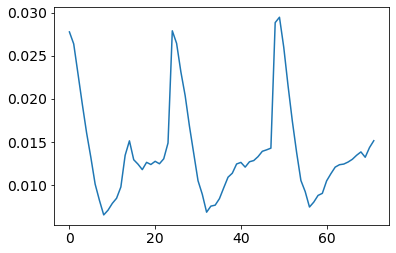

In [15]:
count_l = []
for i in range(72):
    count_l.append(hour_df.hours.value_counts()[i])
count_l = np.array(count_l)
hour_dist = count_l/sum(count_l)
plt.plot(hour_dist)

# read publisher nodes with fraud labels

In [18]:
U = set(pub_df['partnerid'])
V = set(click_df['iplong'])
bad_pubs = set(pub_df.loc[pub_df['status']!='OK']['partnerid'].values)
print(len(bad_pubs))
fraud_pubs = set(pub_df.loc[pub_df['status']=='Fraud']['partnerid'].values)
print(len(fraud_pubs))

153
82


In [19]:
node_mapping = {}
node_ind = 0
for u in U:
    node_mapping[u] = node_ind
    node_ind += 1
for v in V:
    node_mapping[v] = node_ind
    node_ind += 1

In [24]:
bad = [node_mapping[i] for i in bad_pubs]
fraud = [node_mapping[i] for i in fraud_pubs]
U_map = [node_mapping[i] for i in U]

In [22]:
def peel_by_edge_buzzcity(U, bad, fraud, node_dict, fib_heap, edge_list, least_nodes, log=True, log_interval=1):
    total_degree = sum([edge[2] for edge in edge_list])
    n = node_dict.__len__()
    avg_degree = (float)(total_degree) / n
    node_list = list(node_dict.keys())
    max_avg = avg_degree
    S_size = n
    U_losts = [len(U)]
    bad_losts = [len(bad)]
    fraud_losts = [len(fraud)]

    for i in range(n - least_nodes):

        # find min node from graph (remove from heap)
        node_to_remove = fib_heap.extract_min().value

        for motif_type_index in range(len(node_dict[node_to_remove][0].motif_list)):
            for edge_index in node_dict[node_to_remove][0].motif_list[motif_type_index]:
                total_degree -= edge_list[edge_index][2]
                for each_node in edge_list[edge_index][:2]:
                    if each_node!= node_to_remove:
                        fib_heap.decrease_key(node_dict[each_node][1], node_dict[each_node][1].key-edge_list[edge_index][2])
                        node_dict[each_node][0].motif_list[motif_type_index].remove(edge_index)

        del node_dict[node_to_remove]
    
        avg_degree = (float)(total_degree) / (n - i - 1)
        if node_to_remove in U:
            U_losts.append(U_losts[-1]-1)
            if node_to_remove in bad:
                bad_losts.append(bad_losts[-1]-1)
            else:
                bad_losts.append(bad_losts[-1])
            if node_to_remove in fraud:
                fraud_losts.append(fraud_losts[-1]-1)
            else:
                fraud_losts.append(fraud_losts[-1])
        
        if max_avg < avg_degree:
            max_avg = avg_degree
            node_list = list(node_dict.keys())
            S_size = n - i - 1
        if log and i%log_interval==0:
            print('iteration', i, 'to remove node', node_to_remove)
            print(fib_heap.total_nodes, avg_degree, max_avg)
    return max_avg, node_list, S_size, U_losts, bad_losts, fraud_losts

# Heuristic peeling. Edge (u,v) weight = $\chi ^2_u * \chi ^2_v$, Where $\chi ^2_u$ is the chi square statistics between global histogram and histogram of timestamps of edges connecting to node u.

In [20]:
hour_edgelist = []
for edge in hour_df.values:
    hour_edgelist.append((node_mapping[edge[0]], node_mapping[edge[1]], edge[2]))

node_chisquares = node_chisquare(hour_edgelist, node_ind, hour_dist)

In [ ]:
pairs = []
removed_nodes = []
for edge in hour_edgelist:
    pairs.append((edge[0], edge[1],node_chisquares[edge[0]]*node_chisquares[edge[1]]))
# for i in range(peel_times):
#     print('!!', len(pairs[0][0]))
node_d, fibheap = init_heap_dict_weighted(pairs)
hour_results = peel_by_edge_buzzcity(U_map, bad, fraud, node_d, fibheap, pairs, 1, log=True, log_interval=10000)


In [26]:
pickle.dump(hour_results, open('buzzcity_chisquare_allhours.pkl','wb'))

# We also calculate chi square statistics with minute bins and second bins, process omitted here.

## Besides, we use number of clicks between nodes as edge weight, and applied dense subgraph peeling as comparison. Below is a figure report the result. Note all these peeling heuristics are sequential, thus we show the performance as follow: x-axis represents the number of publisher nodes remain in the subgraph being peeled, and y-axis shows the number of fraud publishers within. $\chi ^2$ peeling with hour and minute bins outperform in our result.

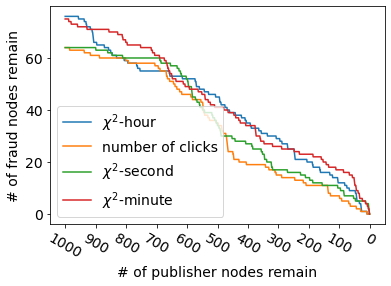

In [21]:
plt.plot(hour_results[5][-1000:],label=r'$\chi^2$-hour')
plt.plot(edge_weight_results[5][-1000:],label='number of clicks')
plt.plot(sec_results[5][-1000:],label=r'$\chi^2$-second')
plt.plot(results[5][-1000:],label=r'$\chi^2$-minute')
plt.xticks(range(0, 1100, 100), range(1000,-100,-100), rotation=-30)
plt.legend()
plt.xlabel('# of publisher nodes remain')
plt.ylabel('# of fraud nodes remain')
plt.savefig('figs/buzzcity/dsdcompare.png')
plt.show()